In [6]:
import os
import datetime
import string

# define parameters
source = "washington"
arch = "flor"
epochs = 10
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/washington.hdf5
output ../output/washington/flor
target ../output/washington/flor/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


In [7]:
import tensorflow as tf
print("Running on:", "GPU" if tf.test.gpu_device_name() else "CPU")

Running on: CPU


In [3]:
from data.generator import DataGenerator

dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

Train images: 325
Validation images: 168
Test images: 163


In [4]:
from network.model import HTRModel

# create and compile HTRModel
model = HTRModel(architecture=arch,
                 input_size=input_size,
                 vocab_size=dtgen.tokenizer.vocab_size,
                 beam_width=10,
                 stop_tolerance=20,
                 reduce_tolerance=15,
                 reduce_factor=0.1)

model.compile(learning_rate=0.001)
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1024, 128, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 512, 64, 16)       160       
                                                                 
 p_re_lu (PReLU)             (None, 512, 64, 16)       16        
                                                                 
 batch_normalization (Batch  (None, 512, 64, 16)       112       
 Normalization)                                                  
                                                                 
 full_gated_conv2d (FullGat  (None, 512, 64, 16)       4640      
 edConv2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 64, 32)       4640  

In [7]:
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)

total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 35.2712
Epoch 1: val_loss improved from 37.85942 to 33.50905, saving model to ../output/washington/flor/checkpoint_weights.hdf5
21/21 [==============================] - 26s 1s/step - loss: 35.2712 - val_loss: 33.5090 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 34.3054
Epoch 2: val_loss improved from 33.50905 to 30.67560, saving model to ../output/washington/flor/checkpoint_weights.hdf5
21/21 [==============================] - 27s 1s/step - loss: 34.3054 - val_loss: 30.6756 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 30.4061
Epoch 3: val_loss improved from 30.67560 to 29.11805, saving model to ../output/washington/flor/checkpoint_weights.hdf5
21/21 [==============================] - 26s 1s/step - loss: 30.4061 - val_loss: 29.1180 - lr: 0.0010
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 29.1220
Epoch 4: val_loss did not impr

In [8]:
from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(pp.adjust_to_see(item))
    print(ground_truth[i])
    print(predicts[i], "\n")

ModuleNotFoundError: No module named 'google.colab'

Model Predict
11/11 [==============================] - 3s 238ms/step
CTC Decode
11/11 [==============================] - 3s 253ms/step



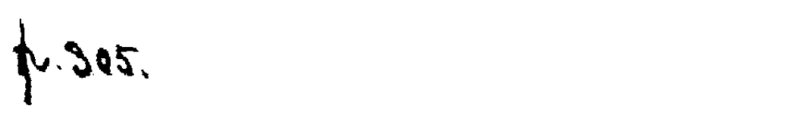

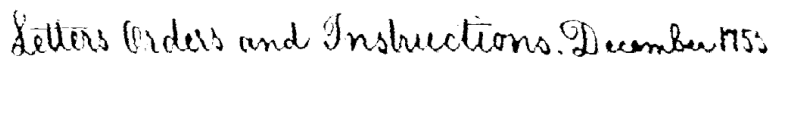

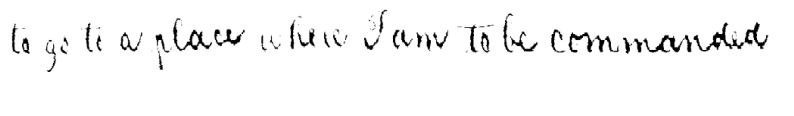

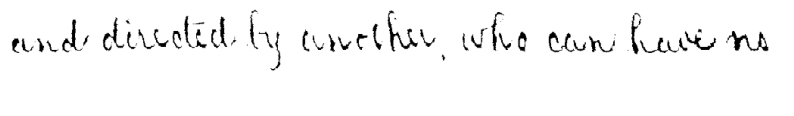

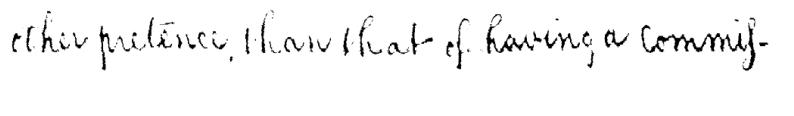

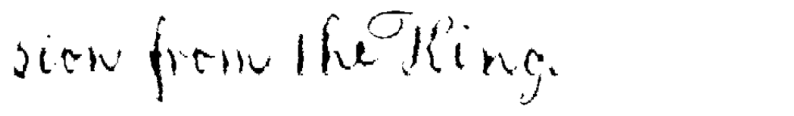

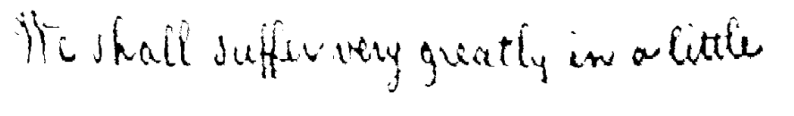

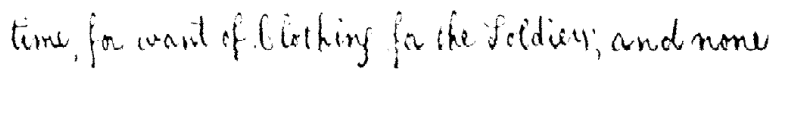

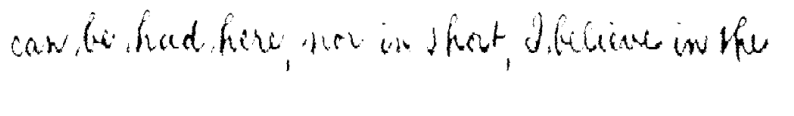

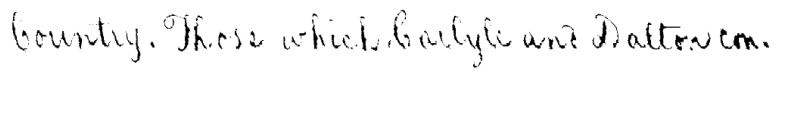

In [9]:
import os
import datetime
import matplotlib.pyplot as plt
from data import preproc as pp

# Track start time
start_time = datetime.datetime.now()

# Predict using the model
predicts, _ = model.predict(
    x=dtgen.next_test_batch(),
    steps=dtgen.steps['test'],
    ctc_decode=True,
    verbose=1
)

# Decode predictions and ground truth to strings
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset['test']['gt']]

# Calculate total time
total_time = datetime.datetime.now() - start_time

# Save predictions to a file
output_path = "/Users/saideepikaneeluru/Downloads/handwritten-text-recognition-master/output"  # Specify your desired output path
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, ground_truth):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")

# Display the first 10 test images and their predictions
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")

    # Use matplotlib to display the image
    plt.figure(figsize=(10, 5))
    plt.imshow(pp.adjust_to_see(item), cmap='gray')  # Assuming the images are grayscale
    plt.axis('off')  # Hide axes
    plt.show()


In [18]:

# Add the path to the src directory if it's not already in your PYTHONPATH
import sys
sys.path.append("Downloads/handwritten-text-recognition-master/src/")

# Import the evaluation function
from data import evaluation

evaluate = evaluation.ocr_metrics(predicts, ground_truth)

e_corpus = "\n".join([
    f"Total test images:    {dtgen.size['test']}",
    f"Total time:           {total_time}",
    f"Time per item:        {total_time / dtgen.size['test']}\n",
    f"Metrics:",
    f"Character Error Rate: {evaluate[0]:.8f}",
    f"Word Error Rate:      {evaluate[1]:.8f}",
    f"Sequence Error Rate:  {evaluate[2]:.8f}"
])

with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
    lg.write(e_corpus)
    print(e_corpus)

Total test images:    163
Total time:           0:00:06.179045
Time per item:        0:00:00.037908

Metrics:
Character Error Rate: 0.19001124
Word Error Rate:      0.51992050
Sequence Error Rate:  0.99386503
